### Import Libraries

In [37]:
# Librerie per lettura file
import pandas as pd
from pathlib import Path
import json
import os
import psutil
import numpy as np
from tqdm import tqdm
import warnings
import pickle
import joblib

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    precision_score, recall_score, roc_auc_score, average_precision_score, f1_score
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
)




#Kfold and GridSearch

from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV



# Grafici
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Data Analysis
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    precision_recall_curve, classification_report, confusion_matrix,
    roc_curve, roc_auc_score, average_precision_score
)
from imblearn.over_sampling import SMOTE
from sklearn.multioutput import MultiOutputRegressor

# Modelli con Alberi
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from lightgbm import LGBMClassifier, LGBMRegressor


# Librerie Torch per MLP
import torch
import pytorch_lightning as pl
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, SubsetRandomSampler
from torchmetrics import F1Score, Accuracy, Precision, Recall
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

# Explainable AI (SHAP)
import shap

# Librerie per gestione dati parallela
import modin.pandas as mpd
import modin.config as cfg

# Visualizzazione matrice di confusione
from sklearn.metrics import ConfusionMatrixDisplay

import shap
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder


In this section, we will test the models on patient data, categorizing them as Responders (including both Partial Responders and Responders) and Non-Responders.
We will evaluate the models using three different approaches described in the article.

## Reading and Preprocessing

In [38]:
df_clean = pd.read_csv("Preprocessing/transcrittoma_pulito.csv")
score_df = pd.read_csv("Preprocessing/drug_scores_with_targets.csv")
score_df.head(31)

,Drug,Score,Drug_name,Targets
0,1248.0,NaN,FK866,['NAMPT']
1,290.0,0.179823,KIN001-260,['IKK-complex']
2,306.0,0.168887,TG101348,['JAK2']
3,222.0,0.162292,BX-912,['PDPK1']
4,329.0,0.161085,QL-XI-92,['DDR1']
5,265.0,0.151817,Tubastatin A,['HDAC6']
6,326.0,0.142042,GSK690693,['AKT']
7,253.0,0.140113,XMD14-99,"['CAMK1', 'EPHB3']"
8,257.0,0.137881,NPK76-II-72-1,['PLK3']
9,309.0,0.136929,Y-39983,"['ROCK2', 'ROCK1']"


In [39]:
df_drug = df_clean[df_clean['Drug_id']==306]

df_paz = pd.read_csv("pazienti/trans_zscore1_15.csv")

df_paz

,Unnamed: 0,Sample,Patient,SampleType,Response_Fedratinib,APEX1,AR,ATF1,ATF5,ATF6,...,ZBTB16,ZBTB7A,ZEB1,ZEB2,ZFHX3,ZFPM2,ZIC1,ZNF148,ZNF384,ZNF91
0,1,A30212,100016,Primary AML,Responder,1.843275,1.640065,1.895687,1.288596,0.893388,...,0.481820,-0.140252,1.956304,1.227944,0.269372,-1.255463,1.282479,0.166825,-2.271562,-0.749405
1,2,A30231,100474,Primary AML,Partial Responder,1.460020,1.242517,2.155088,1.691757,2.621161,...,1.095595,-0.557226,1.622090,1.344116,-0.250616,-1.393083,0.956219,-0.567228,-2.693357,-0.411537
2,3,A31288,100348,Primary AML,Responder,0.805241,1.132355,2.053203,1.818743,1.954662,...,0.515821,-0.617088,1.587309,1.711159,0.185702,-1.207134,0.989671,-0.550602,-2.184994,-0.346119
3,4,A31338,90454,Primary AML,Responder,2.070497,0.946202,2.622732,1.117160,1.089495,...,0.659013,-0.280687,1.834580,1.549226,1.100933,-1.233764,1.146592,0.350118,-1.613094,0.010448
4,5,A31360,90543,Primary AML,Partial Responder,1.330349,1.311771,1.784028,1.658331,0.468698,...,-0.001000,-1.045741,1.591941,0.856083,0.617723,-1.013008,0.873000,0.154174,-2.625518,-0.940600
5,6,A31372,90481,Primary AML,Partial Responder,1.537685,1.878751,1.516135,0.516951,1.876458,...,1.289762,-0.760360,1.918694,1.558127,0.152343,-1.377317,0.786430,-0.330136,-2.259751,-0.804230
6,7,A31387,90668,Primary AML,Non Responder,1.285406,1.610689,1.330520,0.873202,0.568123,...,0.358307,-1.096795,1.659901,1.075388,0.338105,-1.405025,1.313016,0.487281,-2.161474,-0.914187
7,8,A31388,100274,Primary AML,Responder,1.440981,2.110541,1.612618,1.822570,0.477935,...,0.605116,-0.568780,1.180279,1.382499,0.047696,-1.460158,0.986973,0.148318,-2.346983,-0.762941
8,9,A31390,100454,Primary AML,Partial Responder,1.761109,2.085026,1.924771,1.553491,0.533833,...,0.493720,-0.781355,1.555407,0.627580,0.014419,-1.092720,0.465959,0.800317,-2.091325,-0.237988
9,10,A31406,100183,Primary AML,Responder,1.573990,1.122878,2.041615,0.670987,2.570628,...,0.578722,-0.758769,1.570990,1.677377,0.401248,-1.299954,0.937938,0.106872,-2.491128,-0.594170


In [40]:
max_ic50_sensitive = df_drug[df_drug["Sensitivity"] == 1]["IC50"].max()
print("Valore massimo di IC50 tra i campioni sensibili:", max_ic50_sensitive)
min_ic50_sensitive = df_drug[df_drug["Sensitivity"] == 0]["IC50"].min()
print("Valore minimo di IC50 tra i campioni sensibili:", min_ic50_sensitive)

Valore massimo di IC50 tra i campioni sensibili: 0.4889384
Valore minimo di IC50 tra i campioni sensibili: 0.5033922


In [41]:
labels = df_paz['Response_Fedratinib']
df_paz['Sensitivity'] = df_paz['Response_Fedratinib'].isin(['Partial Responder', 'Responder']).astype(int)

#df_paz['Sensitivity'] = df_paz['Response_Fedratinib']
df_paz = df_paz.drop(columns=['Unnamed: 0','SampleType','Patient','Response_Fedratinib'])
df_paz['Drug_Target'] = 67
df_paz['Target_clean'] = 75

In [42]:
cols_to_check = df_clean.iloc[:, 9:].columns

missing_cols = [col for col in cols_to_check if col not in df_paz.columns]

print(len(missing_cols))



for col in missing_cols:
    mean_val = df_clean[col].median()
    df_paz[col] = mean_val

df_paz['cell_name']=df_paz['Sample']
cols_to_drop = [col for col in df_paz.columns if col not in df_clean.columns]
df_paz.drop(columns=cols_to_drop, inplace=True)

common_cols = [col for col in df_clean.columns if col in df_paz.columns]
df_paz = df_paz[common_cols]

df_paz

4


,cell_name,Sensitivity,Target_clean,Drug_Target,AP1,AR,ATF6,ATOH1,CEBPB,CEBPD,...,ZEB1,ZEB2,ZFP42,ZFPM1,ZFPM2,ZIC1,ZNF148,ZNF382,ZNF384,ZNF91
0,A30212,1,75,67,1.000232,1.640065,0.893388,-2.340171,1.802381,0.220965,...,1.956304,1.227944,-1.879259,1.601829,-1.255463,1.282479,0.166825,-1.397868,-2.271562,-0.749405
1,A30231,1,75,67,0.604885,1.242517,2.621161,-2.463904,0.734251,-0.910887,...,1.622090,1.344116,-1.443642,0.971424,-1.393083,0.956219,-0.567228,-2.557524,-2.693357,-0.411537
2,A31288,1,75,67,0.976594,1.132355,1.954662,-2.226525,1.638248,-0.512856,...,1.587309,1.711159,-1.396565,0.890309,-1.207134,0.989671,-0.550602,-1.506321,-2.184994,-0.346119
3,A31338,1,75,67,1.462231,0.946202,1.089495,-3.274355,1.314143,-0.472758,...,1.834580,1.549226,-2.080552,1.312083,-1.233764,1.146592,0.350118,-2.046804,-1.613094,0.010448
4,A31360,1,75,67,1.162931,1.311771,0.468698,-2.662721,0.800941,-0.792836,...,1.591941,0.856083,-0.796022,2.071658,-1.013008,0.873000,0.154174,-1.475383,-2.625518,-0.940600
5,A31372,1,75,67,0.928537,1.878751,1.876458,-2.762881,-0.403124,-1.731300,...,1.918694,1.558127,-0.990990,0.668739,-1.377317,0.786430,-0.330136,-2.302459,-2.259751,-0.804230
6,A31387,0,75,67,1.911299,1.610689,0.568123,-2.535522,1.955657,0.187031,...,1.659901,1.075388,-1.139409,0.567266,-1.405025,1.313016,0.487281,-1.763879,-2.161474,-0.914187
7,A31388,1,75,67,1.526426,2.110541,0.477935,-2.178402,0.340329,-0.688848,...,1.180279,1.382499,-1.366751,0.756969,-1.460158,0.986973,0.148318,-1.197193,-2.346983,-0.762941
8,A31390,1,75,67,1.042715,2.085026,0.533833,-2.469498,1.294753,-0.703060,...,1.555407,0.627580,-0.808300,0.714869,-1.092720,0.465959,0.800317,-2.040708,-2.091325,-0.237988
9,A31406,1,75,67,1.881627,1.122878,2.570628,-2.664452,1.092562,-0.107671,...,1.570990,1.677377,-1.834978,0.795611,-1.299954,0.937938,0.106872,-1.302168,-2.491128,-0.594170


In [43]:
df_nan_sens = df_clean[df_clean["Sensitivity"].isna()]  
df_clean = df_clean[df_clean["Sensitivity"].notna()] 

## Test

### Test Sensitivity

#### Modelli ad albero

In [44]:
def evaluate_model_directory(model_dir, df, labels, drug_name="TG101348", best_threshold = 0.4):
  
    """
    Evaluate an ensemble of trained models stored in the specified directory.
    
    This function:
    - Loads 5 trained models and their AUC_PR scores as weights.
    - Encodes categorical features and prepares the dataset for prediction.
    - Computes weighted predicted probabilities and binary predictions based on the threshold already calculated
    - Plots the confusion matrix and precision-recall vs. threshold curves.
    - Calculates and prints performance metrics (ROC AUC, AUC PR, F1 score).
    - Ranks samples by predicted probability and returns a sorted DataFrame.
    - Generates SHAP explanations for individual predictions, saving waterfall and bar plots.
    
    Parameters:
    - model_dir (str): Directory containing trained models.
    - df (pd.DataFrame): Input data with features and true labels.
    - labels (list): Response Fedratinib.
    - drug_name (str): Prefix used in model filenames (default: "TG101348").
    - best_threshold (float): Probability cutoff to classify samples (default: 0.4).
    
    Returns:
    - df_sorted (pd.DataFrame): DataFrame sorted by predicted probability with original labels.
    """

    shap_dir = f"{model_dir}_SHAP"
    os.makedirs(shap_dir, exist_ok=True)

    individual_dir = os.path.join(shap_dir, "individuals")
    os.makedirs(individual_dir, exist_ok=True)

    # Model
    models = []
    for fold in range(5):
        path = f"{model_dir}/{drug_name}_models/model_fold_{fold}.pkl"
        model_info = joblib.load(path)
        models.append(model_info)

    new_df = df.copy()
    le_cell = LabelEncoder()
    new_df['cell_name'] = le_cell.fit_transform(new_df['cell_name'].astype(str))
    X_new = new_df.drop(columns=["Sensitivity"])

    # Predict Probabilities and Sensitivities
    weights = np.array([m["auc_pr"] for m in models])
    weights = weights / weights.sum()
    y_pred_prob = sum(weights[i] * models[i]["model"].predict_proba(X_new)[:, 1] for i in range(len(models)))
    y_pred = (y_pred_prob > best_threshold).astype(int)
    
    # Cutoff
    cutoff_range = np.arange(y_pred_prob.min(), y_pred_prob.max(), 0.01)
    precisions_cutoff = []
    recalls_cutoff = []
    true_labels = np.array(new_df["Sensitivity"])
    for cutoff in cutoff_range:
        predicted_labels = (y_pred_prob > cutoff).astype(int)
        precisions_cutoff.append(precision_score(true_labels, predicted_labels, zero_division=0))
        recalls_cutoff.append(recall_score(true_labels, predicted_labels, zero_division=0))
        

    probabilities = np.array(y_pred_prob)
    sorted_indices = np.argsort(probabilities)[::-1]
    sorted_probabilities = probabilities[sorted_indices]
    sorted_labels = np.array(labels)[sorted_indices]

    # Print results
    print(f"\nEvaluation for {model_dir}")
    print(f"ROC AUC: {roc_auc_score(true_labels, y_pred_prob):.3f}")
    print(f"AUC PR: {average_precision_score(true_labels, y_pred_prob):.3f}")
    print(f"F1 Score: {f1_score(true_labels, y_pred):.3f}")

    # COnfusion Matrix
    cm = confusion_matrix(true_labels, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non Responder", "Responder"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix @ Best Threshold ({best_threshold:.2f})")
    plt.grid(False)
    plt.show()
    
    # PR
    plt.figure(figsize=(7, 4))
    plt.plot(cutoff_range, precisions_cutoff, marker='o', label='Precision', color='blue')
    plt.plot(cutoff_range, recalls_cutoff, marker='x', label='Recall', color='orange')
    plt.title(f'Precision-Recall vs Threshold: {model_dir.split("/")[-1]}')
    plt.xlabel("Probability Cut-off")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Dictionary
    df_sorted = pd.DataFrame({
        'Original Index': sorted_indices,
        'Sorted Probabilities': sorted_probabilities,
        'Original Label': sorted_labels
    })

    print(df_sorted)


    # SHAP
    explainer = shap.TreeExplainer(models[0]["model"], feature_perturbation="tree_path_dependent")
    shap_values = explainer.shap_values(X_new)

    expected_value = explainer.expected_value
    if isinstance(expected_value, (list, np.ndarray)):
        expected_value = expected_value[1] if len(expected_value) > 1 else expected_value[0]

    ## SHAP for individual patients
    for i in range(X_new.shape[0]):
        plt.figure()

        if isinstance(shap_values, list):
            shap_value = shap_values[1][i]
        else:
            shap_value = shap_values[i] 

        if model_dir == "Results/Models_Sensitivity/RF":
            shap_value = shap_values[i, :, 1] 

        shap_series = pd.Series(shap_value, index=X_new.columns)
        top5_neg = shap_series.sort_values().head(5)
        top5_pos = shap_series.sort_values(ascending=False).head(5)
        combined = pd.concat([top5_neg, top5_pos])
        colors = ['skyblue'] * 5 + ['lightcoral'] * 5

        # Waterfall plot
        shap.plots.waterfall(
            shap.Explanation(
                values=shap_value,
                base_values=expected_value,
                data=X_new.iloc[i],
                feature_names=X_new.columns.tolist()
            ),
            max_display=10,
            show=False
        )
        plt.tight_layout()
        plt.savefig(f"{individual_dir}/shap_example_{i}.png")
        plt.close()


        # Shap top 5
        plt.figure(figsize=(6, 4))
        plt.barh(combined.index[::-1], combined.values[::-1], color=colors[::-1])
        plt.axvline(0, color='gray', linestyle='--', alpha=0.7)
        plt.title(f"Top 5 ± SHAP - {i}", fontsize=12)
        plt.xlabel("SHAP Value (Effect)")
        plt.ylabel("Features")
        plt.tight_layout()
        plt.savefig(f"{individual_dir}/shap_top5_{i}.png", format="png", dpi=300)
        plt.close()



    return df_sorted


#### model_sensitivity

Results/Models_Sensitivity/XGB

Evaluation for Results/Models_Sensitivity/XGB
ROC AUC: 0.750
AUC PR: 0.935
F1 Score: 0.889


<Figure size 640x480 with 0 Axes>

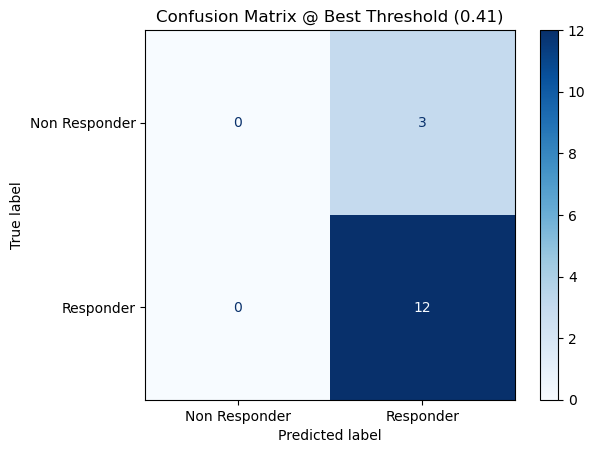

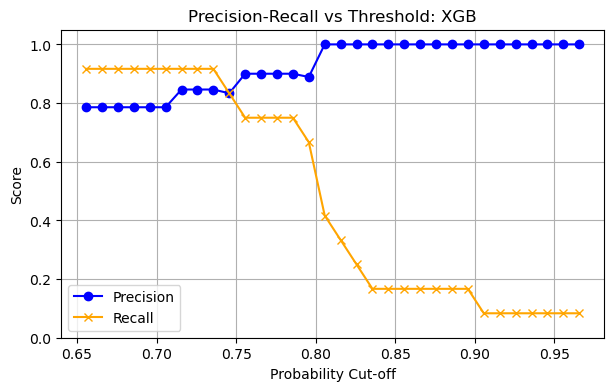

    Original Index  Sorted Probabilities     Original Label
0                8              0.967530  Partial Responder
1                1              0.896554  Partial Responder
2                4              0.827032  Partial Responder
3                5              0.822924  Partial Responder
4               11              0.808637          Responder
5                3              0.803912          Responder
6               10              0.801389      Non Responder
7                7              0.800294          Responder
8                9              0.799581          Responder
9                2              0.793773          Responder
10              14              0.749209          Responder
11              13              0.745924      Non Responder
12              12              0.742840          Responder
13               6              0.713498      Non Responder
14               0              0.655674          Responder
Results/Models_Sensitivity/XGB_RF_GB

Ev

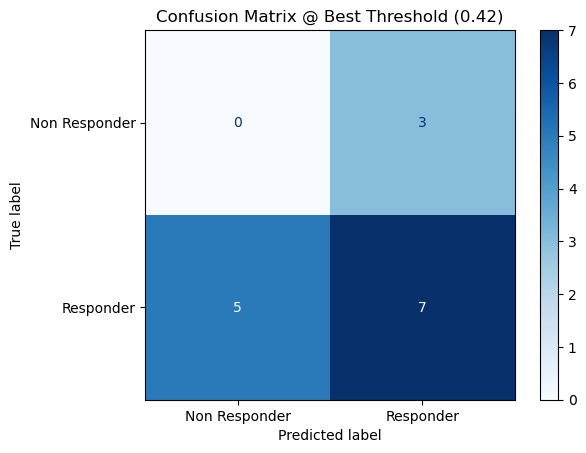

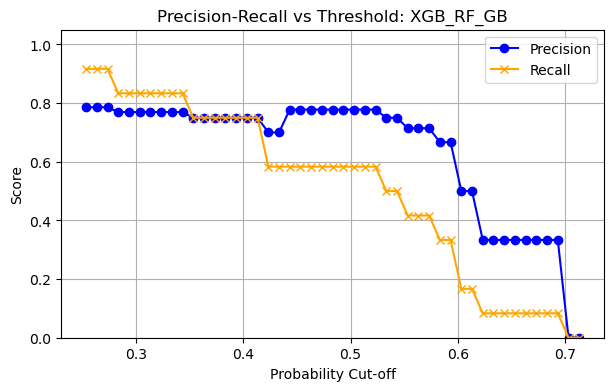

    Original Index  Sorted Probabilities     Original Label
0               10              0.715354      Non Responder
1               13              0.704846      Non Responder
2               14              0.702641          Responder
3                8              0.619255  Partial Responder
4                4              0.600887  Partial Responder
5                1              0.600476  Partial Responder
6                5              0.581025  Partial Responder
7                7              0.550593          Responder
8               11              0.528960          Responder
9                6              0.443164      Non Responder
10               0              0.421433          Responder
11               2              0.415554          Responder
12              12              0.348605          Responder
13               3              0.280690          Responder
14               9              0.253214          Responder
Results/Models_Sensitivity/Gradient_Boos

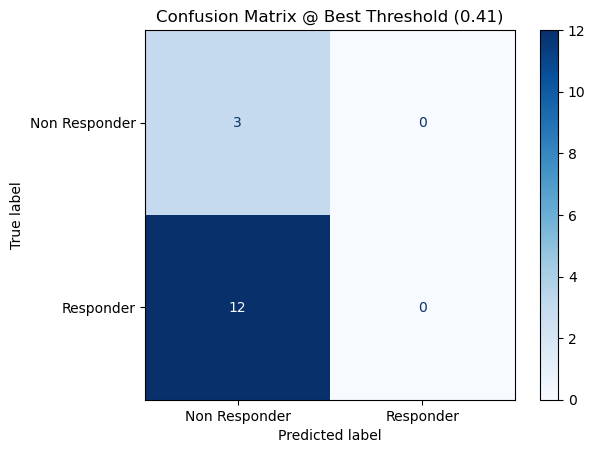

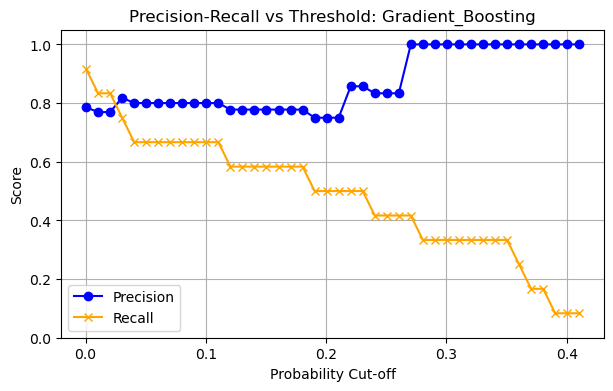

    Original Index  Sorted Probabilities     Original Label
0                1              0.411901  Partial Responder
1                5              0.387260  Partial Responder
2                7              0.360653          Responder
3               14              0.353421          Responder
4               11              0.271343          Responder
5               10              0.267016      Non Responder
6                4              0.235347  Partial Responder
7               13              0.216659      Non Responder
8                9              0.186102          Responder
9                8              0.111027  Partial Responder
10              12              0.031594          Responder
11               6              0.028258      Non Responder
12               3              0.022763          Responder
13               0              0.000592          Responder
14               2              0.000399          Responder
Results/Models_Sensitivity/RF

Evaluatio

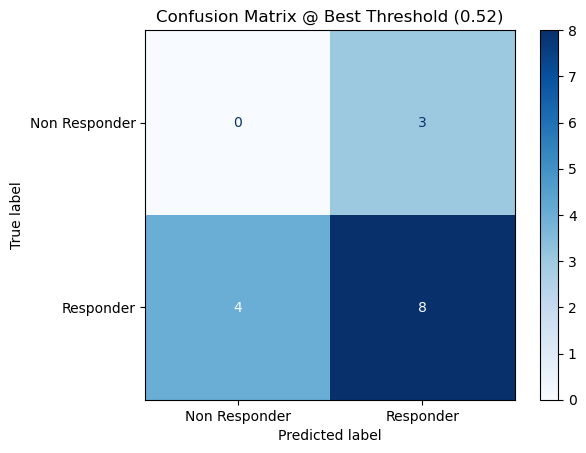

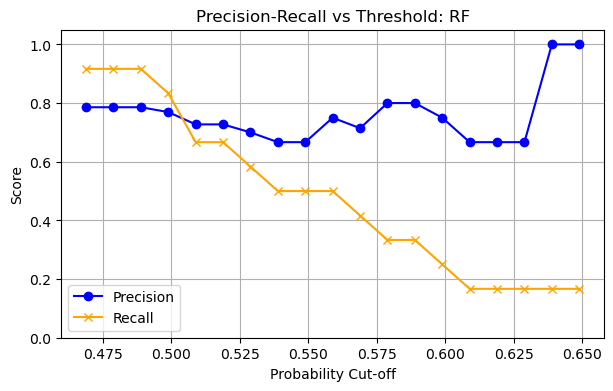

    Original Index  Sorted Probabilities     Original Label
0               14              0.652104          Responder
1                4              0.650278  Partial Responder
2               10              0.631170      Non Responder
3                5              0.601838  Partial Responder
4                1              0.592119  Partial Responder
5               11              0.578788          Responder
6               13              0.575375      Non Responder
7                7              0.559541          Responder
8                6              0.556719      Non Responder
9                8              0.532733  Partial Responder
10               2              0.521471          Responder
11              12              0.506294          Responder
12               3              0.503414          Responder
13               0              0.497582          Responder
14               9              0.468902          Responder


In [45]:
# Directories
drug_models_dirs = [
    "Results/Models_Sensitivity/XGB",
    "Results/Models_Sensitivity/XGB_RF_GB",
    "Results/Models_Sensitivity/Gradient_Boosting",
    "Results/Models_Sensitivity/RF",
]

#RUn the function with the threshold calculaated on the cell lines
df_sorted_list = []
best_threshold = [0.411,0.425, 0.412,0.516]
for i in range(len(best_threshold)):
    model_dir = drug_models_dirs[i]
    print(model_dir)
    bt = best_threshold[i]
    df_sorted = evaluate_model_directory(model_dir, df_paz, labels,best_threshold=bt)
    df_sorted_list.append(df_sorted)

#### Rete neurale

In [46]:
def evaluate_neural_ensemble(model_dir, df, top_features_path, label_col="Sensitivity", drug_name="Drug", best_threshold = 0.5):

    """
    Evaluate an ensemble of trained neural network models on a classification task.
    
    This function:
    - Loads top-ranked input features and uses them to prepare the dataset.
    - Loads multiple neural network models trained on different folds.
    - Predicts class probabilities using a weighted ensemble (based on models' AUC PR).
    - Generates binary predictions using a specified threshold.
    - Computes and displays evaluation metrics: ROC AUC, AUC PR, F1 score.
    - Plots confusion matrix and precision-recall vs. threshold curves.
    - Sorts samples by predicted probability and returns them in a DataFrame.
    
    Parameters:
    - model_dir (str): Directory containing trained neural network models.
    - df (pd.DataFrame): Dataset with features and target labels.
    - top_features_path (str): Path to CSV file containing top-ranked feature names.
    - label_col (str): Name of the column with true binary labels (default: "Sensitivity").
    - drug_name (str): Name of the drug or model label for plot titles (default: "Drug").
    - best_threshold (float): Probability cutoff for classification (default: 0.5).
    
    Returns:
    - df_sorted (pd.DataFrame): DataFrame with sample indices, sorted predicted probabilities, and original labels.
    """

    best_features = pd.read_csv(top_features_path, index_col=0)
    top_features = best_features.index.tolist()

    # Models
    n_folds = 5
    models = []
    for fold in range(n_folds):
        model_path = f"{model_dir}/model_fold_{fold}.pkl"
        model_info = joblib.load(model_path)
        models.append(model_info)

    X = df[top_features].copy()
    y = df[label_col].values
    X_input = np.array(X).astype(np.float32)
    X_input = X_input.reshape((X_input.shape[0], X_input.shape[1], 1))  

    #Predict probabilities and sensitivities  
    weights = np.array([m["auc_pr"] for m in models])
    weights /= weights.sum()
    y_pred_prob = sum(
        weights[i] * models[i]["model"].predict(X_input)[:, 0]
        for i in range(n_folds)
    )
    y_pred = (y_pred_prob > best_threshold).astype(int)

    # Cutoff
    cutoff_range = np.arange(y_pred_prob.min(), y_pred_prob.max(), 0.01)
    precisions_cutoff, recalls_cutoff = [], []
    for cutoff in cutoff_range:
        preds = (y_pred_prob > cutoff).astype(int)
        precisions_cutoff.append(precision_score(y, preds, zero_division=0))
        recalls_cutoff.append(recall_score(y, preds, zero_division=0))

    probabilities = np.array(y_pred_prob)
    sorted_indices = np.argsort(probabilities)[::-1]
    sorted_probabilities = probabilities[sorted_indices]
    sorted_labels = np.array(labels)[sorted_indices]

    # Print results
    print(f"\n Evaluation - {drug_name}")
    print(f"ROC AUC: {roc_auc_score(y, y_pred_prob):.3f}")
    print(f"AUC PR: {average_precision_score(y, y_pred_prob):.3f}")
    print(f"F1 Score: {f1_score(y, y_pred):.3f}")

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non Responder", "Responder"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix @ Best Threshold ({best_threshold:.2f})")
    plt.grid(False)
    plt.show()

    # PR
    plt.figure(figsize=(7, 4))
    plt.plot(cutoff_range, precisions_cutoff, marker='o', label='Precision', color='blue')
    plt.plot(cutoff_range, recalls_cutoff, marker='x', label='Recall', color='orange')
    plt.xlabel("Probability Cut-off")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.title(f"Precision & Recall vs Threshold - {drug_name}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Dictionary
    df_sorted = pd.DataFrame({
        'Original Index': sorted_indices,
        'Sorted Probabilities': sorted_probabilities,
        'Original Label': sorted_labels
    })

    print(df_sorted)

    return df_sorted


##### cnn

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

 Evaluation - TG101348
ROC AUC: 0.167
AUC PR: 0.688
F1 Score: 0.444


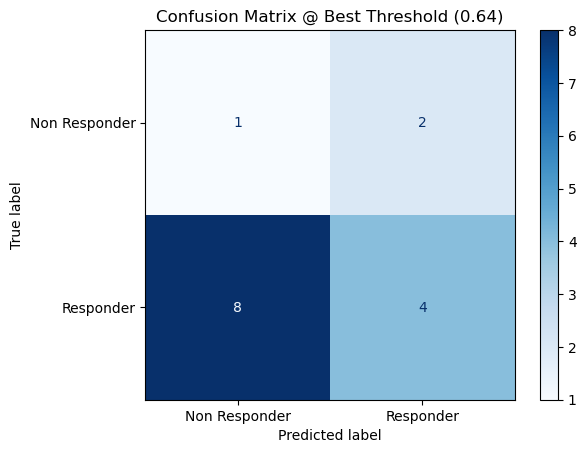

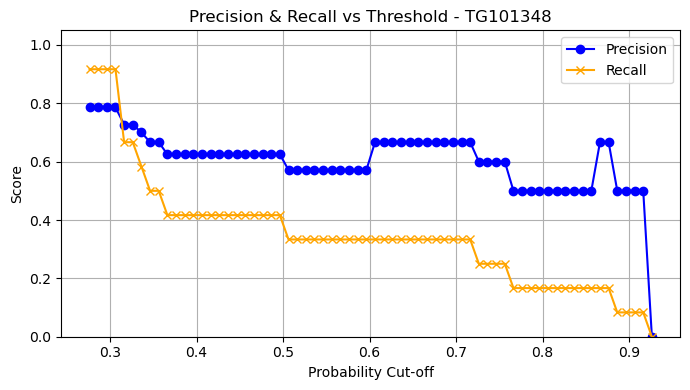

    Original Index  Sorted Probabilities     Original Label
0               10              0.936003      Non Responder
1               14              0.918703          Responder
2                5              0.885599  Partial Responder
3               13              0.856923      Non Responder
4               11              0.761996          Responder
5                4              0.718686  Partial Responder
6                6              0.604063      Non Responder
7                1              0.500151  Partial Responder
8                7              0.365081          Responder
9                8              0.337469  Partial Responder
10               2              0.328085          Responder
11               9              0.315600          Responder
12               3              0.308886          Responder
13               0              0.308636          Responder
14              12              0.276336          Responder


In [47]:
df_sorted_cnn = evaluate_neural_ensemble(
    model_dir="Results/Models_Sensitivity/cnn_Sensitivity/TG101348_models",
    df=df_paz,
    top_features_path="Results/Models_Sensitivity/RF/TG101348/top20_features.csv",
    label_col="Sensitivity",
    drug_name="TG101348",
    best_threshold = 0.636
)


##### MLP

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

 Evaluation - TG101348
ROC AUC: 0.222
AUC PR: 0.708
F1 Score: 0.526


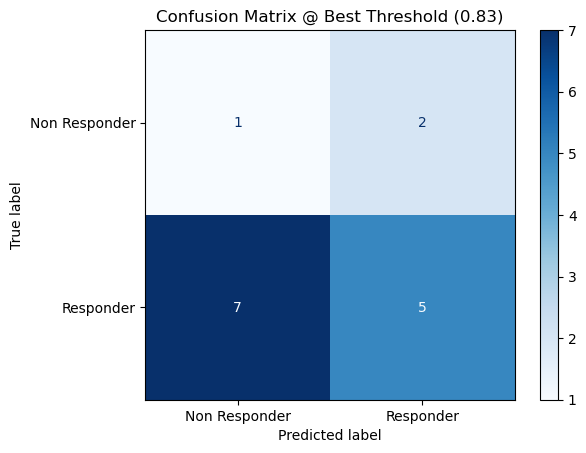

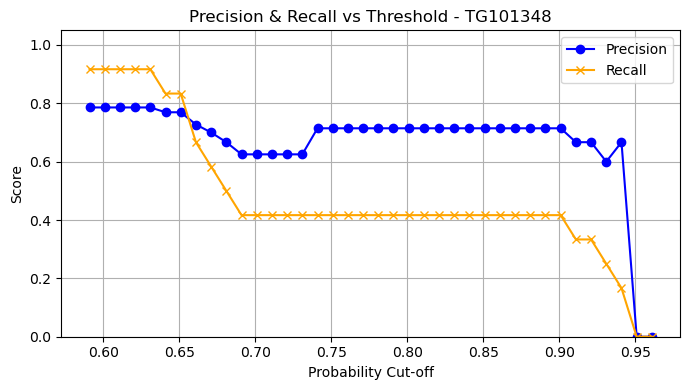

    Original Index  Sorted Probabilities     Original Label
0               10              0.963378      Non Responder
1                1              0.941613  Partial Responder
2               14              0.941609          Responder
3                4              0.933489  Partial Responder
4               13              0.932506      Non Responder
5                5              0.922552  Partial Responder
6               11              0.909946          Responder
7                6              0.737043      Non Responder
8                3              0.689214          Responder
9                2              0.672166          Responder
10               8              0.664835  Partial Responder
11               9              0.654747          Responder
12               0              0.653519          Responder
13              12              0.639483          Responder
14               7              0.591007          Responder


In [48]:
df_sorted_cnn = evaluate_neural_ensemble(
    model_dir="Results/Models_Sensitivity/mlp_Sensitivity/TG101348_models",
    df=df_paz,
    top_features_path="Results/Models_Sensitivity/RF/TG101348/top20_features.csv",
    label_col="Sensitivity",
    drug_name="TG101348",
    best_threshold=0.832
)


### Test IC50

#### Modelli ad albero

In [49]:
def evaluate_model_directory_ic50(model_dir, df_test, labels, drug_name="TG101348", cutoff = 0.5):

    """
    Evaluate an ensemble of trained models stored in the specified directory.
    
    This function:
    - Loads 5 trained models and their AUC_PR scores as weights.
    - Encodes categorical features and prepares the dataset for prediction.
    - Predict IC50 and sensitivity predictions based on the threshold already calculated
    - Plots the confusion matrix and precision-recall vs. threshold curves.
    - Calculates and prints performance metrics (ROC AUC, AUC PR, F1 score).
    - Ranks samples by predicted probability and returns a sorted DataFrame.
    - Generates SHAP explanations for individual predictions, saving waterfall and bar plots.
    
    Parameters:
    - model_dir (str): Directory containing trained models.
    - df_test (pd.DataFrame): Input data with features and true labels.
    - labels (list): Response Fedratinib.
    - drug_name (str): Prefix used in model filenames (default: "TG101348").
    - best_threshold (float): Probability cutoff to classify samples (default: 0.5).
    
    Returns:
    - df_sorted (pd.DataFrame): DataFrame sorted by predicted IC50 with original labels.
    """


    #models
    models = []
    for fold in range(5):
        path = f"{model_dir}/{drug_name}_models/model_fold_{fold}.pkl"
        model_info = joblib.load(path)
        models.append(model_info)

    new_df = df_test.copy()
    le_cell = LabelEncoder()
    new_df['cell_name'] = le_cell.fit_transform(new_df['cell_name'].astype(str))
    X_new = new_df.drop(columns=["Sensitivity",'cell_name'])

    #Predict Ic50 and sensitivityies
    y_pred_ic50 = np.mean([m.predict(X_new) for m in models], axis=0)
    y_pred_sens = (y_pred_ic50 < cutoff).astype(int)
    true_labels = np.array(new_df["Sensitivity"])

    # Cutoff
    cutoff_range = np.arange(y_pred_ic50.min(), y_pred_ic50.max(), 0.1)
    precisions_cutoff = []
    recalls_cutoff = []

    for c in cutoff_range:
        predicted_sens = (y_pred_ic50 < c).astype(int)
        precisions_cutoff.append(precision_score(true_labels, predicted_sens, zero_division=0))
        recalls_cutoff.append(recall_score(true_labels, predicted_sens, zero_division=0))

    # COnfusion Matrix
    cm = confusion_matrix(true_labels, y_pred_sens)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non Responder", "Responder"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix @ IC50 Cutoff (percentile {cutoff})")
    plt.grid(False)
    plt.show()

    # Pr
    plt.figure(figsize=(7, 4))
    plt.plot(cutoff_range, precisions_cutoff, marker='o', label='Precision', color='blue')
    plt.plot(cutoff_range, recalls_cutoff, marker='x', label='Recall', color='orange')
    plt.title(f'Precision-Recall vs Predicted IC50 Cutoff: {model_dir.split("/")[-1]}')
    plt.xlabel("IC50 Predicted Cut-off")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.show()

    #Print Results
    print(f"\nEvaluation for {model_dir}")
    print(f"F1 Score: {f1_score(true_labels, y_pred_sens):.3f}")
    print(f"Precision: {precision_score(true_labels, y_pred_sens, zero_division=0):.3f}")
    print(f"Recall: {recall_score(true_labels, y_pred_sens, zero_division=0):.3f}")

    #Dictionary
    sorted_indices = np.argsort(y_pred_ic50)
    df_sorted = pd.DataFrame({
        'Original Index': sorted_indices,
        'Predicted IC50': y_pred_ic50[sorted_indices],
        'True Sensitivity': np.array(labels)[sorted_indices]
    })

    print(df_sorted)

    # SHAP directory
    shap_dir = f"{model_dir}_SHAP"
    os.makedirs(shap_dir, exist_ok=True)
    individual_dir = os.path.join(shap_dir, "individuals")
    os.makedirs(individual_dir, exist_ok=True)

   #Shap values
    explainer = shap.TreeExplainer(models[0])
    shap_values = -explainer.shap_values(X_new)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    expected_value = explainer.expected_value
    if isinstance(expected_value, list) or isinstance(expected_value, np.ndarray):
        expected_value = expected_value[0]

    # SHAP for each drug
    N = 15  
    for i in range(min(N, X_new.shape[0])):
        
        # Waterfall plot
        plt.figure()
        shap.plots.waterfall(
            shap.Explanation(
                values=shap_values[i],
                base_values=expected_value,
                data=X_new.iloc[i],
                feature_names=X_new.columns.tolist()
            ),
            max_display=10,
            show=False
        )
        plt.tight_layout()
        plt.savefig(f"{individual_dir}/shap_example_{i}.png")
        plt.close()


        shap_series = pd.Series(shap_values[i], index=X_new.columns)
        top5_neg = shap_series.sort_values().head(5)
        top5_pos = shap_series.sort_values(ascending=False).head(5)
        combined = pd.concat([top5_neg, top5_pos])
        colors = ['skyblue'] * 5 + ['lightcoral'] * 5


        # Shap top 5
        plt.figure(figsize=(6, 4))
        plt.barh(combined.index[::-1], combined.values[::-1], color=colors[::-1])
        plt.axvline(0, color='gray', linestyle='--', alpha=0.7)
        plt.title(f"Top 5 ± SHAP - {i}", fontsize=12)
        plt.xlabel("SHAP Value (Effect)")
        plt.ylabel("Features")
        plt.tight_layout()
        plt.savefig(f"{individual_dir}/shap_top5_{i}.png", format="png", dpi=300)
        plt.close()

    # Shap sumaary plot
    shap.summary_plot(shap_values, X_new, feature_names=X_new.columns, plot_type="bar", show=False)
    plt.title(f"SHAP Bar Plot - {model_dir.split('/')[-1]}")
    plt.tight_layout()
    plt.savefig(f"{shap_dir}/shap_bar_plot.png")
    plt.close()

    return df_sorted

### Neural Network models

In [50]:
def evaluate_neural_ensemble_ic50(model_dir, df, top_features_path, label_col="IC50", drug_name="Drug",cutoff = 0.5):
    """
    Evaluate an ensemble of trained neural networks on IC50 prediction (regression task).
    
    Parameters:
    - model_dir (str): Directory containing trained neural network models.
    - df (pd.DataFrame): Dataset with features and target labels.
    - top_features_path (str): Path to CSV file containing top-ranked feature names.
    - label_col (str): Name of the column with true IC50 values (default: "IC50").
    - drug_name (str): Name of the drug or model label for plot titles.
    
    Returns:
    - df_sorted (pd.DataFrame): DataFrame with sample indices, predicted IC50, and true IC50, sorted by prediction.
    """


    # Load top features
    best_features = pd.read_csv(top_features_path, index_col=0)
    top_features = best_features.index.tolist()

    # Load models
    n_folds = 5
    models = []
    for fold in range(n_folds):
        model_path = f"{model_dir}/model_fold_{fold}.pkl"
        model_info = joblib.load(model_path)
        models.append(model_info)

    # Prepare data
    X = df[top_features].copy()
    y_true = df[label_col].values
    X_input = np.array(X).astype(np.float32)
    X_input = X_input.reshape((X_input.shape[0], X_input.shape[1], 1))

    # Carica i modelli
    models = []
    for fold in range(n_folds):
        model_path = f"{model_dir}/model_fold_{fold}.pkl"
        model = joblib.load(model_path)
        models.append(model)

    # Predizioni
    predictions = np.array([
        model.predict(X_input)[:, 0]
        for model in models
    ])

    # Media semplice sulle predizioni
    y_pred_ic50 = np.mean(predictions, axis=0)
    y_pred_sens = (y_pred_ic50 < cutoff).astype(int)
    true_labels = np.array(df["Sensitivity"])

    # Cutoff
    cutoff_range = np.arange(y_pred_ic50.min(), y_pred_ic50.max(), 0.1)
    precisions_cutoff = []
    recalls_cutoff = []

    for c in cutoff_range:
        predicted_sens = (y_pred_ic50 < c).astype(int)
        precisions_cutoff.append(precision_score(true_labels, predicted_sens, zero_division=0))
        recalls_cutoff.append(recall_score(true_labels, predicted_sens, zero_division=0))

    # COnfusion Matrix
    cm = confusion_matrix(true_labels, y_pred_sens)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non Responder", "Responder"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix @ IC50 Cutoff (percentile {cutoff})")
    plt.grid(False)
    plt.show()

    # Pr
    plt.figure(figsize=(7, 4))
    plt.plot(cutoff_range, precisions_cutoff, marker='o', label='Precision', color='blue')
    plt.plot(cutoff_range, recalls_cutoff, marker='x', label='Recall', color='orange')
    plt.title(f'Precision-Recall vs Predicted IC50 Cutoff: {model_dir.split("/")[-1]}')
    plt.xlabel("IC50 Predicted Cut-off")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.show()

    #Print Results
    print(f"\nEvaluation for {model_dir}")
    print(f"F1 Score: {f1_score(true_labels, y_pred_sens):.3f}")
    print(f"Precision: {precision_score(true_labels, y_pred_sens, zero_division=0):.3f}")
    print(f"Recall: {recall_score(true_labels, y_pred_sens, zero_division=0):.3f}")

    #Dictionary
    sorted_indices = np.argsort(y_pred_ic50)
    df_sorted = pd.DataFrame({
        'Original Index': sorted_indices,
        'Predicted IC50': y_pred_ic50[sorted_indices],
        'True Sensitivity': np.array(labels)[sorted_indices]
    })

    print(df_sorted)


    return df_sorted


##### NO SMOTE

#### tree models

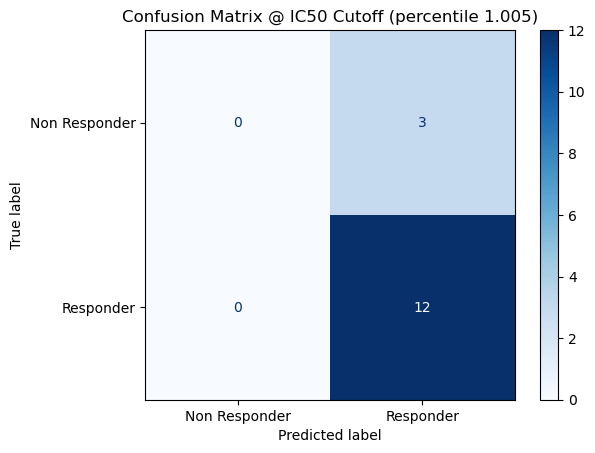

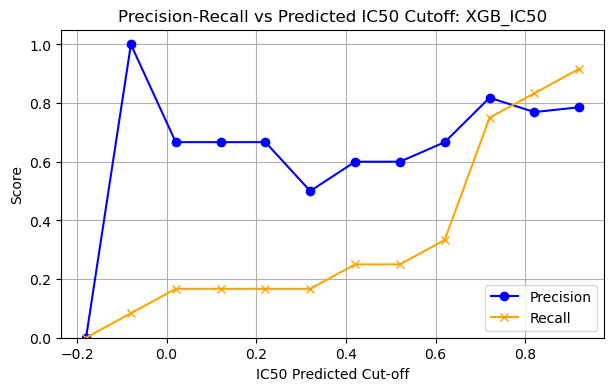


Evaluation for Results/Models_IC50/XGB_IC50
F1 Score: 0.889
Precision: 0.800
Recall: 1.000
    Original Index  Predicted IC50   True Sensitivity
0                4       -0.179640  Partial Responder
1               10       -0.018098      Non Responder
2                8        0.010646  Partial Responder
3               13        0.292326      Non Responder
4                5        0.365517  Partial Responder
5               12        0.599862          Responder
6               11        0.622436          Responder
7               14        0.638546          Responder
8                3        0.660169          Responder
9                7        0.682986          Responder
10               1        0.711415  Partial Responder
11               6        0.720591      Non Responder
12               0        0.808473          Responder
13               9        0.854039          Responder
14               2        0.975191          Responder


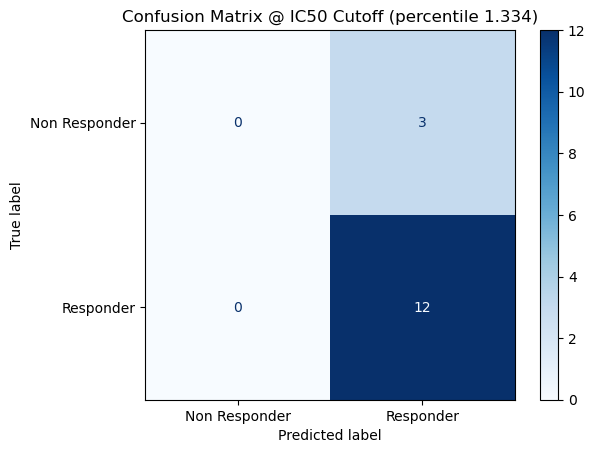

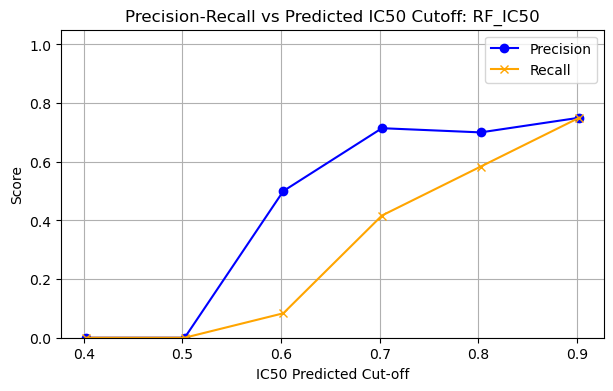


Evaluation for Results/Models_IC50/RF_IC50
F1 Score: 0.889
Precision: 0.800
Recall: 1.000
    Original Index  Predicted IC50   True Sensitivity
0               10        0.402276      Non Responder
1               11        0.587409          Responder
2               13        0.654120      Non Responder
3               14        0.681139          Responder
4                0        0.684936          Responder
5                5        0.687494  Partial Responder
6                4        0.689079  Partial Responder
7                1        0.735603  Partial Responder
8                7        0.764555          Responder
9                6        0.801775      Non Responder
10               9        0.872948          Responder
11               2        0.899154          Responder
12               3        0.908876          Responder
13              12        0.940167          Responder
14               8        0.994027  Partial Responder


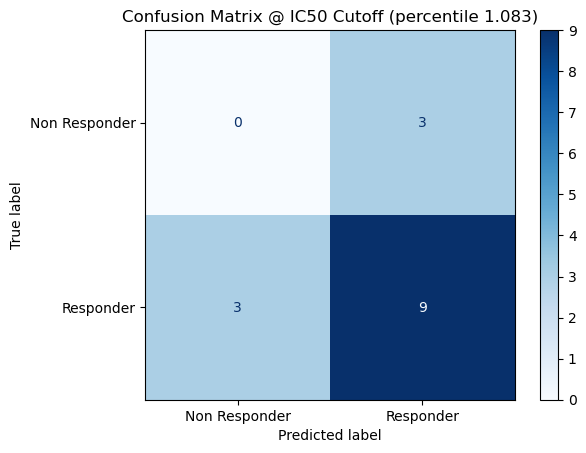

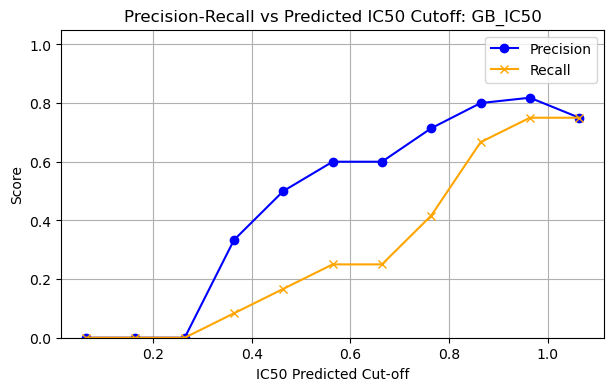


Evaluation for Results/Models_IC50/GB_IC50
F1 Score: 0.750
Precision: 0.750
Recall: 0.750
    Original Index  Predicted IC50   True Sensitivity
0               10        0.064076      Non Responder
1               13        0.193745      Non Responder
2                4        0.294755  Partial Responder
3                8        0.376059  Partial Responder
4                5        0.512742  Partial Responder
5                7        0.700803          Responder
6               11        0.729105          Responder
7                2        0.764785          Responder
8                1        0.805869  Partial Responder
9                0        0.854398          Responder
10               3        0.888934          Responder
11               6        0.964359      Non Responder
12               9        1.085808          Responder
13              12        1.097281          Responder
14              14        1.141008          Responder


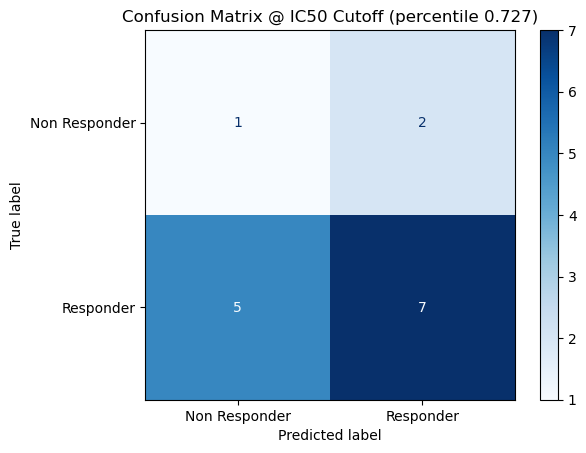

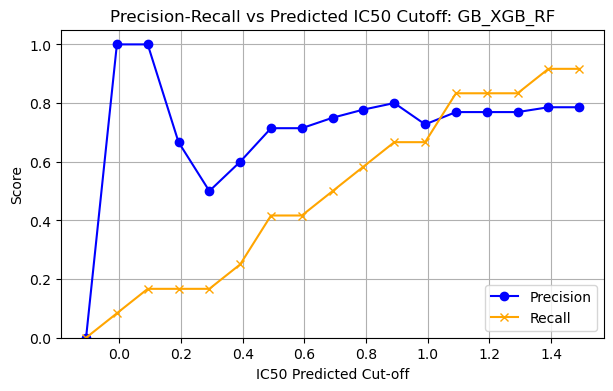


Evaluation for Results/Models_IC50/GB_XGB_RF
F1 Score: 0.667
Precision: 0.778
Recall: 0.583
    Original Index  Predicted IC50   True Sensitivity
0                8       -0.108411  Partial Responder
1                4        0.038335  Partial Responder
2               13        0.153943      Non Responder
3               10        0.197961      Non Responder
4               12        0.360012          Responder
5                7        0.397687          Responder
6                5        0.468979  Partial Responder
7               14        0.689199          Responder
8               11        0.706975          Responder
9                1        0.864885  Partial Responder
10               6        0.968782      Non Responder
11               3        0.991616          Responder
12               0        1.037578          Responder
13               9        1.358189          Responder
14               2        1.506346          Responder


In [51]:
drug_models_dirs = [
    "Results/Models_IC50/XGB_IC50",
    "Results/Models_IC50/RF_IC50",
    "Results/Models_IC50/GB_IC50",
    "Results/Models_IC50/GB_XGB_RF"
]

cut = [1.005,1.334,1.083,0.727] # prese dal grafico 
df_sorted_list = []

for i in range(len(drug_models_dirs)):
    model_dir, cutoff = drug_models_dirs[i],cut[i]
    df_sorted = evaluate_model_directory_ic50(model_dir, df_paz, labels,cutoff = cutoff)
    df_sorted_list.append(df_sorted)


#### MLP

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


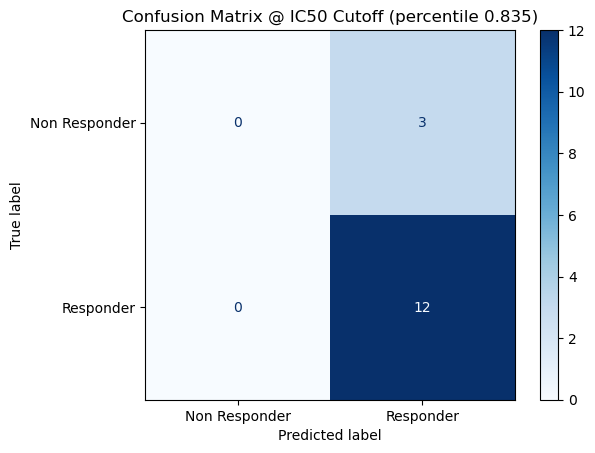

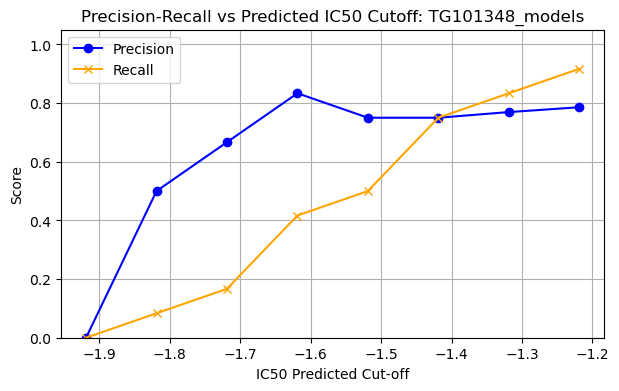


Evaluation for Results/Models_IC50/mlp/TG101348_models
F1 Score: 0.889
Precision: 0.800
Recall: 1.000
    Original Index  Predicted IC50   True Sensitivity
0               10       -1.918805      Non Responder
1                4       -1.893911  Partial Responder
2                1       -1.780756  Partial Responder
3               14       -1.674527          Responder
4                5       -1.666106  Partial Responder
5                0       -1.655574          Responder
6               13       -1.575666      Non Responder
7               11       -1.572073          Responder
8                9       -1.505678          Responder
9                6       -1.485399      Non Responder
10               2       -1.480755          Responder
11               3       -1.463872          Responder
12               8       -1.340383  Partial Responder
13              12       -1.235999          Responder
14               7       -1.217026          Responder


In [52]:
df_sorted_cnn = evaluate_neural_ensemble_ic50(
    model_dir="Results/Models_IC50/mlp/TG101348_models",
    df=df_paz,
    top_features_path='Results/Models_Sensitivity/RF/TG101348/top20_features.csv',
    label_col="Sensitivity",
    drug_name="TG101348",
    cutoff=0.835

)

#### CNN

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


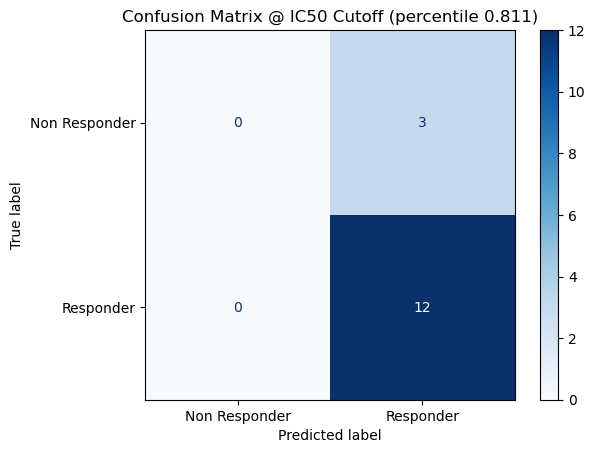

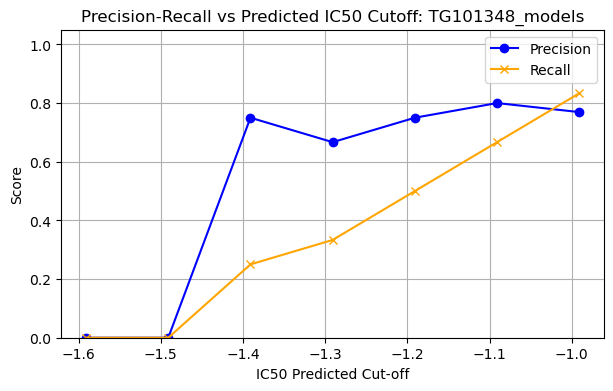


Evaluation for Results/Models_IC50/cnn/TG101348_models
F1 Score: 0.889
Precision: 0.800
Recall: 1.000
    Original Index  Predicted IC50   True Sensitivity
0               10       -1.590970      Non Responder
1               14       -1.470414          Responder
2                4       -1.458826  Partial Responder
3                1       -1.402717  Partial Responder
4                5       -1.370426  Partial Responder
5               13       -1.313784      Non Responder
6               11       -1.267445          Responder
7                9       -1.237971          Responder
8                0       -1.181823          Responder
9                2       -1.110904          Responder
10               6       -1.057293      Non Responder
11               3       -1.052720          Responder
12               8       -1.006546  Partial Responder
13               7       -0.974998          Responder
14              12       -0.909205          Responder


In [53]:
df_sorted_cnn = evaluate_neural_ensemble_ic50(
    model_dir="Results/Models_IC50/cnn/TG101348_models",
    df=df_paz,
    top_features_path='Results/Models_Sensitivity/RF/TG101348/top20_features.csv',
    label_col="Sensitivity",
    drug_name="TG101348",
    cutoff=0.811

)

### SMOTE

#### Tree Models

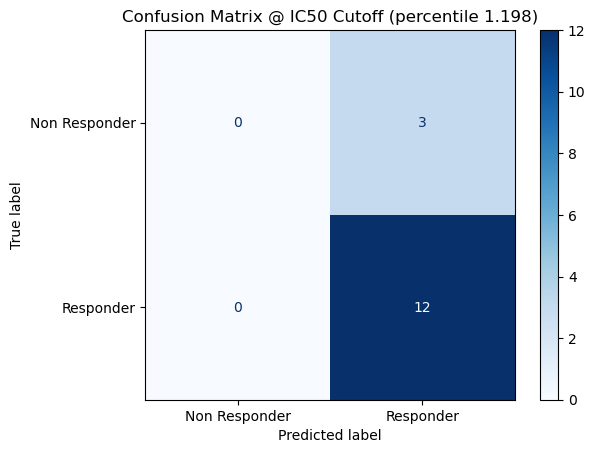

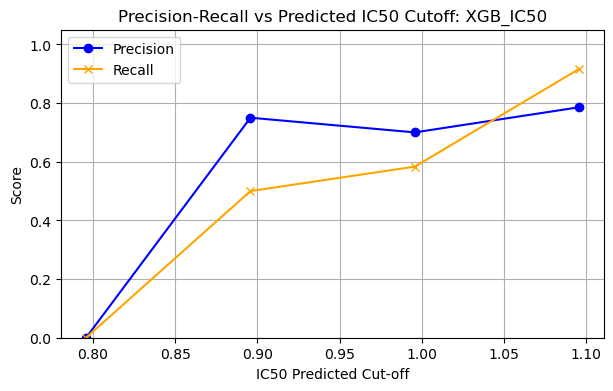


Evaluation for Results/Models_IC50_SMOTE/XGB_IC50
F1 Score: 0.889
Precision: 0.800
Recall: 1.000
    Original Index  Predicted IC50   True Sensitivity
0               14        0.795809          Responder
1                1        0.811255  Partial Responder
2               11        0.817504          Responder
3                5        0.834289  Partial Responder
4               10        0.841955      Non Responder
5                4        0.870731  Partial Responder
6               13        0.879400      Non Responder
7                7        0.887949          Responder
8                6        0.916736      Non Responder
9                8        0.956988  Partial Responder
10               0        1.003980          Responder
11               2        1.014186          Responder
12              12        1.056853          Responder
13               9        1.080523          Responder
14               3        1.125546          Responder


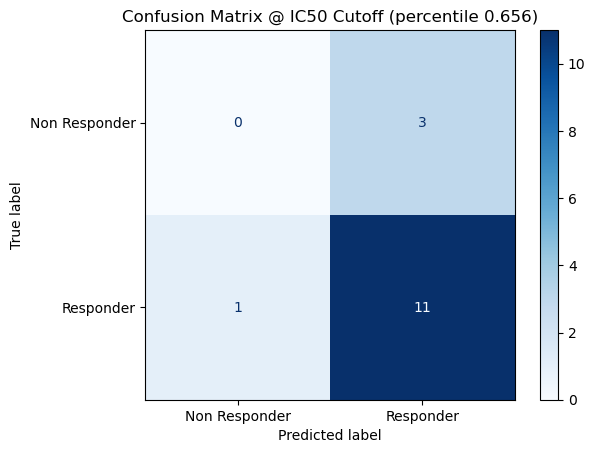

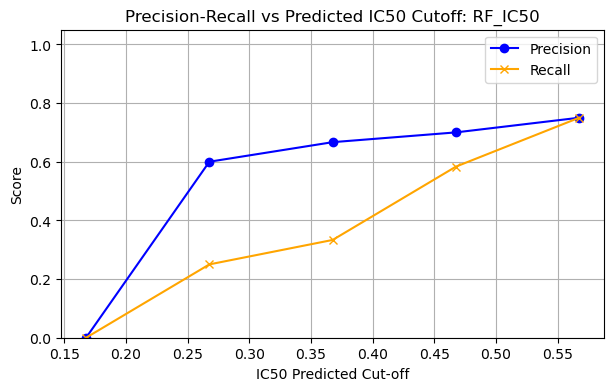


Evaluation for Results/Models_IC50_SMOTE/RF_IC50
F1 Score: 0.846
Precision: 0.786
Recall: 0.917
    Original Index  Predicted IC50   True Sensitivity
0               14        0.167514          Responder
1               10        0.193320      Non Responder
2                4        0.208095  Partial Responder
3               13        0.229143      Non Responder
4                5        0.258432  Partial Responder
5               11        0.294741          Responder
6                1        0.370305  Partial Responder
7                6        0.374442      Non Responder
8                0        0.433650          Responder
9                7        0.460960          Responder
10               8        0.521545  Partial Responder
11              12        0.544005          Responder
12               3        0.617084          Responder
13               2        0.624369          Responder
14               9        0.664707          Responder


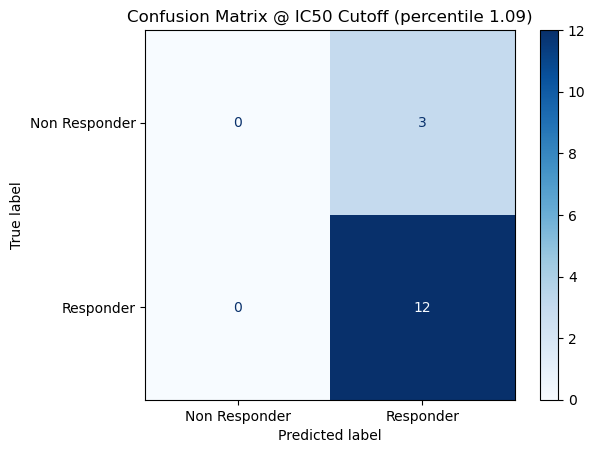

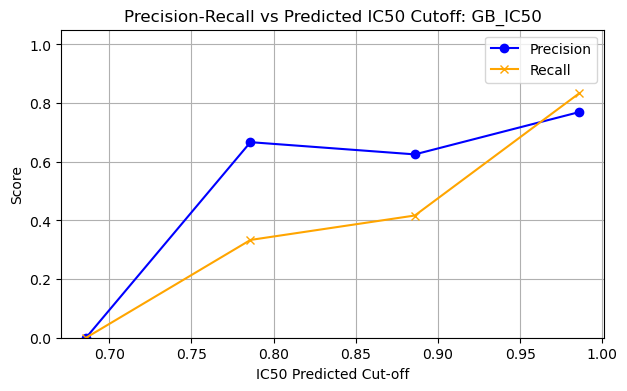


Evaluation for Results/Models_IC50_SMOTE/GB_IC50
F1 Score: 0.889
Precision: 0.800
Recall: 1.000
    Original Index  Predicted IC50   True Sensitivity
0               10        0.685942      Non Responder
1               14        0.702281          Responder
2               11        0.732409          Responder
3                5        0.738596  Partial Responder
4                4        0.748662  Partial Responder
5               13        0.753157      Non Responder
6                1        0.810549  Partial Responder
7                6        0.858890      Non Responder
8                7        0.893456          Responder
9                0        0.919614          Responder
10              12        0.956867          Responder
11               9        0.962565          Responder
12               8        0.969452  Partial Responder
13               3        1.053637          Responder
14               2        1.063554          Responder


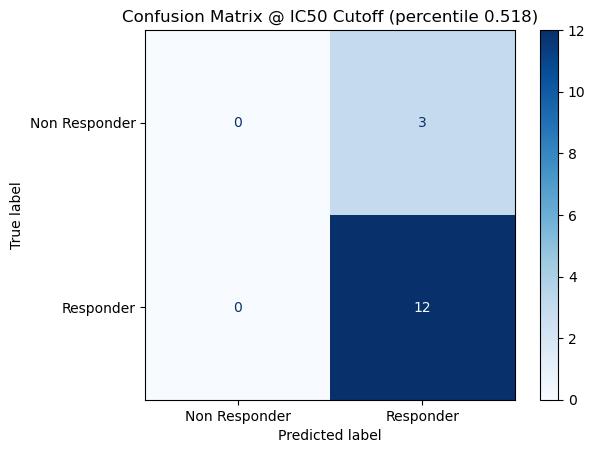

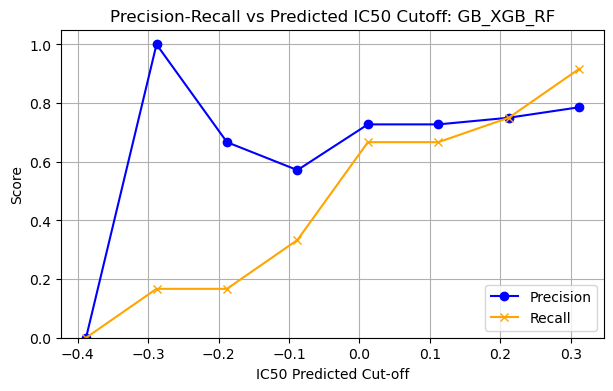


Evaluation for Results/Models_IC50_SMOTE/GB_XGB_RF
F1 Score: 0.889
Precision: 0.800
Recall: 1.000
    Original Index  Predicted IC50   True Sensitivity
0               11       -0.388078          Responder
1               14       -0.356315          Responder
2                6       -0.278027      Non Responder
3               13       -0.169108      Non Responder
4                5       -0.138116  Partial Responder
5                2       -0.105553          Responder
6               10       -0.094752      Non Responder
7                4       -0.079914  Partial Responder
8               12       -0.038450          Responder
9                9       -0.036744          Responder
10               1       -0.012528  Partial Responder
11               7        0.150100          Responder
12               0        0.215473          Responder
13               3        0.236919          Responder
14               8        0.401644  Partial Responder


In [54]:
drug_models_dirs = [
    "Results/Models_IC50_SMOTE/XGB_IC50",
    "Results/Models_IC50_SMOTE/RF_IC50",
    "Results/Models_IC50_SMOTE/GB_IC50",
    "Results/Models_IC50_SMOTE/GB_XGB_RF"
]
cut = [1.198,0.656,1.090,0.518] 
df_sorted_list = []
for i in range(len(drug_models_dirs)):
    model_dir, cutoff = drug_models_dirs[i],cut[i]
    df_sorted = evaluate_model_directory_ic50(model_dir, df_paz, labels,cutoff = cutoff)
    df_sorted_list.append(df_sorted) 

#### MLP

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


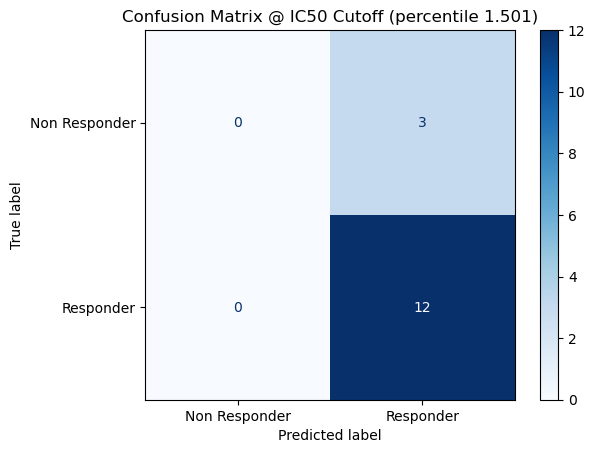

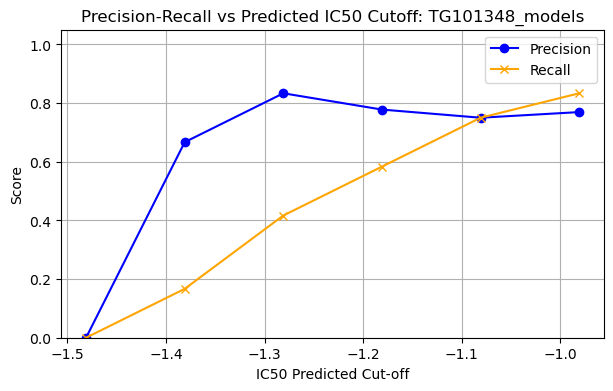


Evaluation for Results/Models_IC50_SMOTE/mlp/TG101348_models
F1 Score: 0.889
Precision: 0.800
Recall: 1.000
    Original Index  Predicted IC50   True Sensitivity
0                4       -1.480933  Partial Responder
1               10       -1.463006      Non Responder
2                0       -1.427183          Responder
3                1       -1.365172  Partial Responder
4                9       -1.298440          Responder
5                5       -1.287828  Partial Responder
6               14       -1.278206          Responder
7                2       -1.234555          Responder
8               13       -1.185154      Non Responder
9                6       -1.163885      Non Responder
10               3       -1.151872          Responder
11              11       -1.131895          Responder
12              12       -1.012971          Responder
13               7       -0.960301          Responder
14               8       -0.939051  Partial Responder


In [55]:
df_sorted_cnn = evaluate_neural_ensemble_ic50(
    model_dir="Results/Models_IC50_SMOTE/mlp/TG101348_models",
    df=df_paz,
    top_features_path='Results/Models_Sensitivity/RF/TG101348/top20_features.csv',
    label_col="Sensitivity",
    drug_name="TG101348",
    cutoff=1.501
)


#### CNN

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


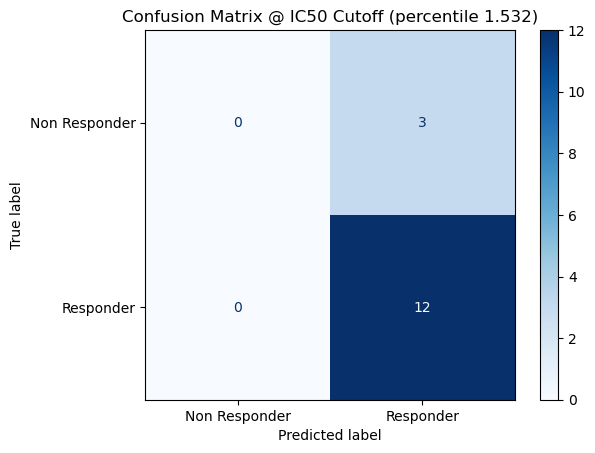

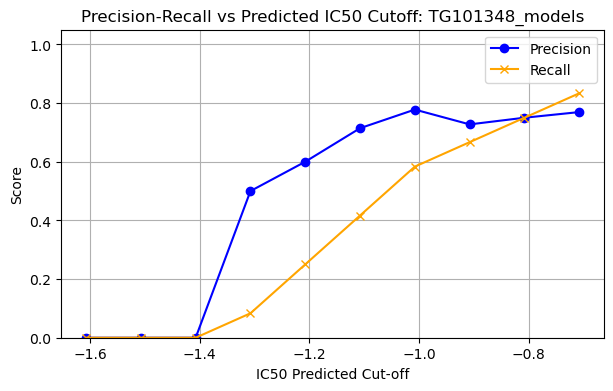


Evaluation for Results/Models_IC50_SMOTE/cnn/TG101348_models
F1 Score: 0.889
Precision: 0.800
Recall: 1.000
    Original Index  Predicted IC50   True Sensitivity
0               10       -1.607628      Non Responder
1                4       -1.342778  Partial Responder
2                5       -1.282271  Partial Responder
3               13       -1.236691      Non Responder
4               14       -1.236090          Responder
5                1       -1.177405  Partial Responder
6                0       -1.149913          Responder
7                9       -1.044992          Responder
8                2       -1.030642          Responder
9                6       -0.942780      Non Responder
10              11       -0.934410          Responder
11               3       -0.880563          Responder
12              12       -0.712055          Responder
13               7       -0.679903          Responder
14               8       -0.629643  Partial Responder


In [56]:
df_sorted_cnn = evaluate_neural_ensemble_ic50(
    model_dir="Results/Models_IC50_SMOTE/cnn/TG101348_models",
    df=df_paz,
    top_features_path='Results/Models_Sensitivity/RF/TG101348/top20_features.csv',
    label_col="Sensitivity",
    drug_name="TG101348",
    cutoff=1.532

)
